#Install Essential Framework

In [ ]:
! pip install -qq fastai --upgrade

     |████████████████████████████████| 189 kB 5.3 MB/s 
     |████████████████████████████████| 55 kB 4.0 MB/s 


In [ ]:
! pip install -qq kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
!gdown --id 1Wq_i3cMpUTHslUP1plzL76SeK66gLLXE 

Downloading...
From: https://drive.google.com/uc?id=1Wq_i3cMpUTHslUP1plzL76SeK66gLLXE
To: /content/kaggle.json
100% 68.0/68.0 [00:00<00:00, 93.4kB/s]


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c super-ai-engineer-2021-house-grade-classification

100% 2.31G/2.31G [00:14<00:00, 152MB/s]
100% 2.31G/2.31G [00:14<00:00, 169MB/s]


In [ ]:
!unzip -qq /content/super-ai-engineer-2021-house-grade-classification.zip 

In [ ]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=afbff608ebb0a2000a2ce7337b936028c08c22a07540830988448d999a910dde
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [ ]:
!git clone https://github.com/d-li14/efficientnetv2.pytorch

Cloning into 'efficientnetv2.pytorch'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 40 (delta 19), reused 9 (delta 4), pack-reused 0
Unpacking objects: 100% (40/40), done.


In [ ]:
!pip install tensorflow==2.8.0
!pip install tensorflow-addons
!pip install focal-loss


     |████████████████████████████████| 462 kB 5.4 MB/s 
     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [ ]:
!pip install fastai wwf timm -q --upgrade

     |████████████████████████████████| 431 kB 7.1 MB/s 


#Import library

In [ ]:
#importing required modules
import gdown
import zipfile
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import datasets, transforms as T
import os
import torch.optim as optim
from PIL import ImageFile
from sklearn.metrics import accuracy_score
import imageio
from tqdm import tqdm

import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import math
import pandas as pd

import fastai
from fastai.vision.all import *
from fastai.vision.augment import *
from fastai.metrics import *

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import tensorflow as tf
#import tensorflow_addons as tfa

##Check CUDA

In [ ]:
#Checking the availability of a GPU
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

cuda


#EDA

In [ ]:
df = pd.read_csv('train.csv')
df.columns = ['fname', 'labels']
df

fname  \
0     ChokChai4_img_13-7956791_100-6031267_a187-21598902886774_s90_y0_f90_1.jpg   
1       ChokChai4_img_13-7961753_100-6031881_a185-978546002526_s90_y0_f90_1.jpg   
2     ChokChai4_img_13-7969811_100-5906061_a180-5812875399312_s270_y0_f90_1.jpg   
3      ChokChai4_img_13-7970811_100-5906071_a180-5812875399312_s90_y0_f90_1.jpg   
4      ChokChai4_img_13-7971811_100-5906081_a180-5812875399312_s90_y0_f90_1.jpg   
...                                                                         ...   
2948             MrtSutthisan_img_13-7986837_100-5730268_a260_s90_y75_f90_0.jpg   
2949             MrtSutthisan_img_13-7990804_100-5729745_a170_s90_y75_f90_0.jpg   
2950             MrtSutthisan_img_13-7991266_100-5728237_a255_s90_y75_f90_0.jpg   
2951              MrtSutthisan_img_13-7992342_100-5710656_a55_s90_y75_f90_0.jpg   
2952             MrtSutthisan_img_13-7994169_100-5727479_a255_s90_y75_f90_0.jpg   

      labels  
0          0  
1          0  
2          0  
3          0  
4          0  
...      ...  
2948       5  
2949       5  
2950       5  
2951       5  
2952       5  

[2953 rows x 2 columns]

In [ ]:
df.labels.value_counts().sum()  

2953

In [ ]:
df.groupby('labels').count()

fname
labels       
0        1520
1          39
2          97
3         318
4         632
5         347

In [ ]:
df.groupby('labels').count().mean()

fname    492.166667
dtype: float64

(array([1520.,    0.,   39.,    0.,   97.,    0.,  318.,    0.,  632.,
         347.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

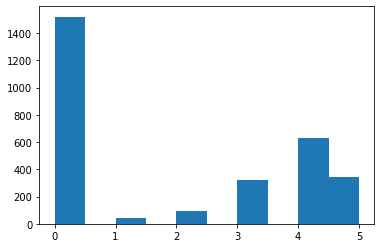

In [ ]:
plt.hist(x=df['labels'])

###Balancing data

In [ ]:
#from torch.utils.data.sampler import WeightedRandomSampler
#
#def sampler_(dataset):
#    dataset_counts = df.groupby('labels').count().fname.to_list()
#    num_samples = sum(dataset_counts)
#    labels = [tag for tag in dataset.labels]
#
#    class_weights = [num_samples/dataset_counts[i] for i in range(len(dataset_counts))]
#    weights = [class_weights[labels[i]] for i in range(num_samples)]
#    sampler = WeightedRandomSampler(torch.DoubleTensor(weights), 3600) #int(num_samples))
#    return sampler


In [ ]:
#Create weight of each Labels

def weights_(dataset=df, n_sample=3000):
    dataset_counts = dataset.groupby('labels').count().fname.to_list() #n_label
    num_samples = sum(dataset_counts) #n_samples
    labels = [tag for tag in dataset.labels]

    class_weights = [num_samples/(len(dataset_counts)*dataset_counts[i]) for i in range(len(dataset_counts))]
    weights = [class_weights[labels[i]] for i in range(num_samples)]
    balance_df = dataset.sample(n_sample, weights=weights, replace=True)

    return balance_df

In [ ]:
#weighted sampling
#try changing n_sample

balance_df = weights_(df,7200)

In [ ]:
balance_df

fname  \
319       img_13-7664595_100-6178746_a171-5691426_s81-56914259999996_y0_f90_1.jpg   
1522     img_13-7489193_100-5906684_a286-6326062_s16-632606199999998_y0_f90_1.jpg   
1527     img_13-7838052_100-5843975_a187-3439031_s277-34390310000003_y0_f90_1.jpg   
2740     img_13-7867591_100-5943749_a261-1135978_s171-11359779999998_y0_f90_1.jpg   
1745      img_13-7813697_100-5783841_a113-7193538_s23-71935380000002_y0_f90_1.jpg   
...                                                                           ...   
1534  img_13-7982968_100-5920153_a272-295741888831_s182-295741888831_y0_f90_1.jpg   
1527     img_13-7838052_100-5843975_a187-3439031_s277-34390310000003_y0_f90_1.jpg   
471            img_13-7834063_100-5995325_a81-53766543_s351-53766543_y0_f90_1.jpg   
2046     img_13-7604346_100-5636125_a283-2852033_s13-285203299999978_y0_f90_1.jpg   
1752     img_13-7824792_100-6261014_a102-3245619_s12-324561899999992_y0_f90_1.jpg   

      labels  
319        0  
1522       1  
1527       1  
2740       5  
1745       3  
...      ...  
1534       1  
1527       1  
471        0  
2046       4  
1752       3  

[7200 rows x 2 columns]

In [ ]:
balance_df.groupby('labels').count()

fname
labels       
0        1211
1        1197
2        1227
3        1184
4        1173
5        1208

(array([1211.,    0., 1197.,    0., 1227.,    0., 1184.,    0., 1173.,
        1208.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

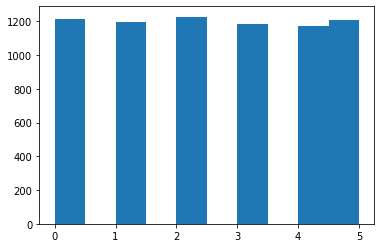

In [ ]:
plt.hist(x=balance_df['labels'])

###Data Augmentation

In [ ]:
tfms = [FlipItem(p=0.75), Zoom(max_zoom=1.1, p = 0.25)]

#Train

In [ ]:
path = '/content/train'
dls = ImageDataLoaders.from_df(balance_df, path,folder=None,  device = 'cuda', item_tfms=Resize(240, 240), batch_tfms=[FlipItem(p=0.75), Zoom(max_zoom=1.1, p = 0.25)])

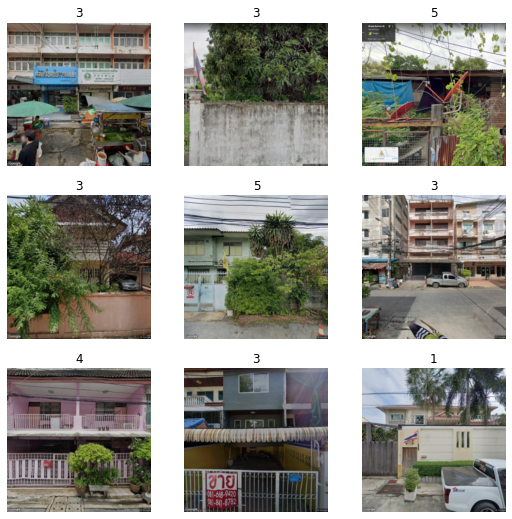

In [ ]:
dls.show_batch()

In [ ]:
from efficientnet_pytorch import EfficientNet

In [ ]:
effnetb1 =  EfficientNet.from_pretrained('efficientnet-b1', num_classes=6)


learn = Learner(dls, 
                    effnetb1, 
                    metrics=[F1Score(average='macro'),error_rate])
# learn.lr_find()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth


  0%|          | 0.00/30.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b1


In [ ]:
#lr_range = learn.lr_find()

In [ ]:
learn.fine_tune(30, 1e-3)

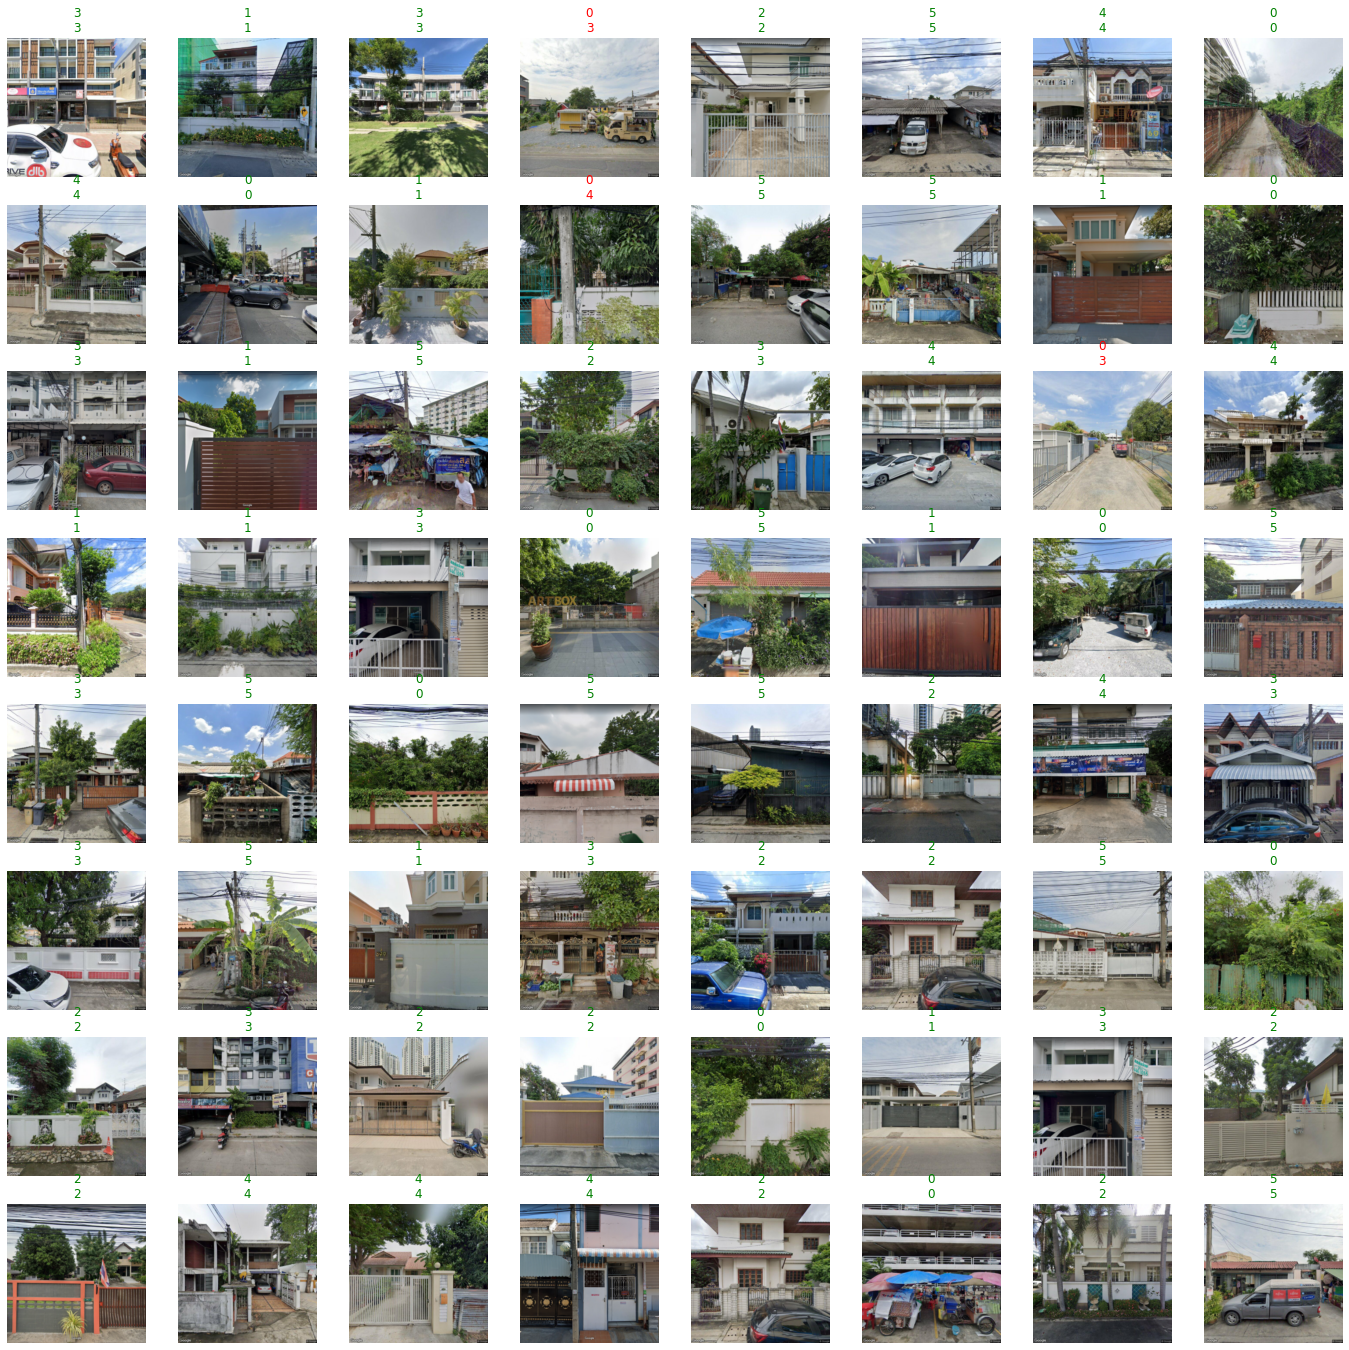

In [ ]:
learn.show_results(max_n=100)

In [ ]:
preds = learn.get_preds(with_decoded=True)

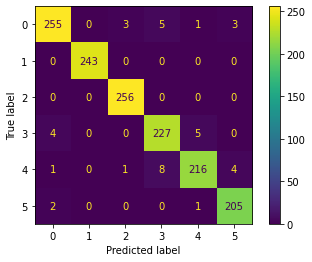

0.9733242684533975

In [ ]:
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, classification_report

ConfusionMatrixDisplay.from_predictions(preds[1], preds[2])
plt.show()
f1_score(preds[1], preds[2], average='macro')

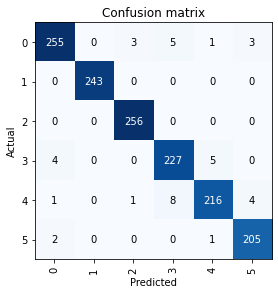

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

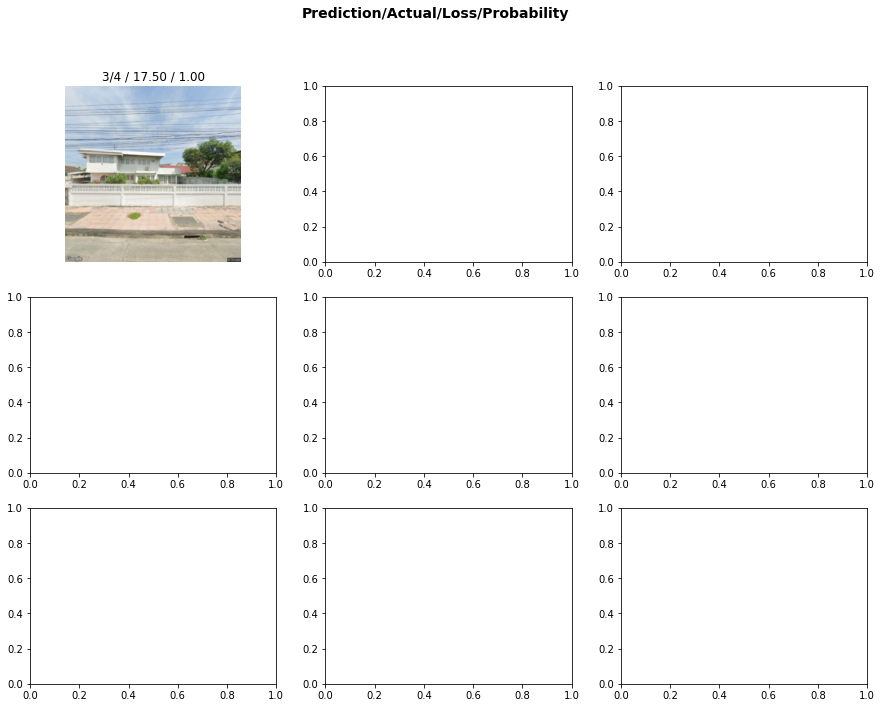

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
print(classification_report(preds[1], preds[2]))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       267
           1       1.00      1.00      1.00       243
           2       0.98      1.00      0.99       256
           3       0.95      0.96      0.95       236
           4       0.97      0.94      0.95       230
           5       0.97      0.99      0.98       208

    accuracy                           0.97      1440
   macro avg       0.97      0.97      0.97      1440
weighted avg       0.97      0.97      0.97      1440



#Prediction

In [ ]:
fnames = get_image_files('/content/test')

In [ ]:
root_dir = '/content/test'
prediction = {'Id': [], 'Predicted': []}
for idx, file in tqdm(enumerate(os.listdir(root_dir))):

    id = file.replace('.jpg', '')

    id_name = id
    prediction['Id'].append(id_name)
    prediction['Predicted'].append(learn.predict(fnames[idx])[0])


0it [00:00, ?it/s]

1it [00:02,  2.14s/it]

2it [00:02,  1.05it/s]

3it [00:02,  1.77it/s]

4it [00:02,  2.60it/s]

5it [00:02,  3.47it/s]

6it [00:02,  4.43it/s]

7it [00:02,  5.39it/s]

8it [00:02,  6.23it/s]

9it [00:03,  6.88it/s]

10it [00:03,  7.46it/s]

11it [00:03,  7.83it/s]

12it [00:03,  8.23it/s]

13it [00:03,  8.52it/s]

14it [00:03,  8.75it/s]

15it [00:03,  8.91it/s]

16it [00:03,  8.95it/s]

17it [00:03,  8.97it/s]

18it [00:03,  9.05it/s]

19it [00:04,  9.08it/s]

20it [00:04,  8.93it/s]

21it [00:04,  9.02it/s]

22it [00:04,  8.98it/s]

23it [00:04,  8.93it/s]

24it [00:04,  9.02it/s]

25it [00:04,  9.15it/s]

26it [00:04,  9.06it/s]

27it [00:04,  9.13it/s]

28it [00:05,  9.07it/s]

29it [00:05,  8.93it/s]

30it [00:05,  8.91it/s]

31it [00:05,  8.93it/s]

32it [00:05,  8.82it/s]

33it [00:05,  8.76it/s]

34it [00:05,  8.82it/s]

35it [00:05,  8.72it/s]

36it [00:06,  8.67it/s]

37it [00:06,  8.63it/s]

38it [00:06,  8.50it/s]

39it [00:06,  8.51it/s]

40it [00:06,  8.54it/s]

41it [00:06,  8.53it/s]

42it [00:06,  8.54it/s]

43it [00:06,  8.58it/s]

44it [00:06,  8.71it/s]

45it [00:07,  8.58it/s]

46it [00:07,  8.43it/s]

47it [00:07,  8.38it/s]

48it [00:07,  8.49it/s]

49it [00:07,  8.50it/s]

50it [00:07,  8.42it/s]

51it [00:07,  8.38it/s]

52it [00:07,  8.52it/s]

53it [00:08,  8.76it/s]

54it [00:08,  8.61it/s]

55it [00:08,  8.67it/s]

56it [00:08,  8.53it/s]

57it [00:08,  8.54it/s]

58it [00:08,  8.70it/s]

59it [00:08,  8.59it/s]

60it [00:08,  8.53it/s]

61it [00:08,  8.55it/s]

62it [00:09,  8.60it/s]

63it [00:09,  8.43it/s]

64it [00:09,  8.36it/s]

65it [00:09,  8.26it/s]

66it [00:09,  8.31it/s]

67it [00:09,  8.34it/s]

68it [00:09,  8.46it/s]

69it [00:09,  8.42it/s]

70it [00:10,  8.43it/s]

71it [00:10,  8.43it/s]

72it [00:10,  8.44it/s]

73it [00:10,  8.38it/s]

74it [00:10,  8.58it/s]

75it [00:10,  8.59it/s]

76it [00:10,  8.76it/s]

77it [00:10,  8.57it/s]

78it [00:10,  8.48it/s]

79it [00:11,  8.45it/s]

80it [00:11,  8.32it/s]

81it [00:11,  8.56it/s]

82it [00:11,  8.36it/s]

83it [00:11,  8.48it/s]

84it [00:11,  8.49it/s]

85it [00:11,  8.46it/s]

86it [00:11,  8.63it/s]

87it [00:12,  8.60it/s]

88it [00:12,  8.62it/s]

89it [00:12,  8.67it/s]

90it [00:12,  8.74it/s]

91it [00:12,  8.46it/s]

92it [00:12,  8.52it/s]

93it [00:12,  8.55it/s]

94it [00:12,  8.46it/s]

95it [00:12,  8.53it/s]

96it [00:13,  8.49it/s]

97it [00:13,  8.46it/s]

98it [00:13,  8.35it/s]

99it [00:13,  8.36it/s]

100it [00:13,  8.24it/s]

101it [00:13,  8.32it/s]

102it [00:13,  8.39it/s]

103it [00:13,  8.37it/s]

104it [00:14,  8.44it/s]

105it [00:14,  8.29it/s]

106it [00:14,  8.29it/s]

107it [00:14,  8.24it/s]

108it [00:14,  7.99it/s]

109it [00:14,  8.16it/s]

110it [00:14,  8.21it/s]

111it [00:14,  8.30it/s]

112it [00:15,  8.40it/s]

113it [00:15,  8.36it/s]

114it [00:15,  8.40it/s]

115it [00:15,  8.49it/s]

116it [00:15,  8.36it/s]

117it [00:15,  8.00it/s]

118it [00:15,  8.07it/s]

119it [00:15,  8.05it/s]

120it [00:15,  8.12it/s]

121it [00:16,  8.09it/s]

122it [00:16,  8.01it/s]

123it [00:16,  8.07it/s]

124it [00:16,  8.14it/s]

125it [00:16,  7.91it/s]

126it [00:16,  7.90it/s]

127it [00:16,  7.95it/s]

128it [00:16,  8.08it/s]

129it [00:17,  8.04it/s]

130it [00:17,  8.01it/s]

131it [00:17,  7.94it/s]

132it [00:17,  7.69it/s]

133it [00:17,  7.56it/s]

134it [00:17,  7.73it/s]

135it [00:17,  7.73it/s]

136it [00:18,  7.86it/s]

137it [00:18,  7.86it/s]

138it [00:18,  7.92it/s]

139it [00:18,  7.84it/s]

140it [00:18,  7.94it/s]

141it [00:18,  7.80it/s]

142it [00:18,  7.81it/s]

143it [00:18,  7.95it/s]

144it [00:19,  7.80it/s]

145it [00:19,  7.75it/s]

146it [00:19,  7.75it/s]

147it [00:19,  7.85it/s]

148it [00:19,  7.83it/s]

149it [00:19,  7.63it/s]

150it [00:19,  7.60it/s]

151it [00:19,  7.67it/s]

152it [00:20,  7.73it/s]

153it [00:20,  7.75it/s]

154it [00:20,  7.76it/s]

155it [00:20,  7.87it/s]

156it [00:20,  7.82it/s]

157it [00:20,  7.73it/s]

158it [00:20,  7.70it/s]

159it [00:20,  7.77it/s]

160it [00:21,  7.74it/s]

161it [00:21,  7.81it/s]

162it [00:21,  7.82it/s]

163it [00:21,  7.87it/s]

164it [00:21,  7.87it/s]

165it [00:21,  7.80it/s]

166it [00:21,  7.81it/s]

167it [00:21,  7.85it/s]

168it [00:22,  7.91it/s]

169it [00:22,  7.86it/s]

170it [00:22,  7.71it/s]

171it [00:22,  7.65it/s]

172it [00:22,  7.51it/s]

173it [00:22,  7.41it/s]

174it [00:22,  7.47it/s]

175it [00:23,  7.54it/s]

176it [00:23,  7.64it/s]

177it [00:23,  7.66it/s]

178it [00:23,  7.65it/s]

179it [00:23,  7.78it/s]

180it [00:23,  7.77it/s]

181it [00:23,  7.61it/s]

182it [00:23,  7.52it/s]

183it [00:24,  7.47it/s]

184it [00:24,  7.42it/s]

185it [00:24,  7.30it/s]

186it [00:24,  7.20it/s]

187it [00:24,  7.35it/s]

188it [00:24,  7.49it/s]

189it [00:24,  7.39it/s]

190it [00:25,  7.49it/s]

191it [00:25,  7.42it/s]

192it [00:25,  7.49it/s]

193it [00:25,  7.38it/s]

194it [00:25,  7.37it/s]

195it [00:25,  7.34it/s]

196it [00:25,  7.30it/s]

197it [00:26,  7.32it/s]

198it [00:26,  7.32it/s]

199it [00:26,  7.44it/s]

200it [00:26,  7.45it/s]

201it [00:26,  7.36it/s]

202it [00:26,  7.45it/s]

203it [00:26,  7.62it/s]

204it [00:26,  7.38it/s]

205it [00:27,  7.28it/s]

206it [00:27,  7.31it/s]

207it [00:27,  7.32it/s]

208it [00:27,  7.44it/s]

209it [00:27,  7.35it/s]

210it [00:27,  7.37it/s]

211it [00:27,  7.38it/s]

212it [00:28,  7.22it/s]

213it [00:28,  7.20it/s]

214it [00:28,  7.30it/s]

215it [00:28,  7.27it/s]

216it [00:28,  7.38it/s]

217it [00:28,  7.31it/s]

218it [00:28,  7.28it/s]

219it [00:29,  7.11it/s]

220it [00:29,  7.36it/s]

221it [00:29,  7.37it/s]

222it [00:29,  7.45it/s]

223it [00:29,  7.44it/s]

224it [00:29,  7.29it/s]

225it [00:29,  7.30it/s]

226it [00:29,  7.44it/s]

227it [00:30,  7.28it/s]

228it [00:30,  7.31it/s]

229it [00:30,  7.35it/s]

230it [00:30,  7.36it/s]

231it [00:30,  7.32it/s]

232it [00:30,  7.43it/s]

233it [00:30,  7.45it/s]

234it [00:31,  7.34it/s]

235it [00:31,  7.35it/s]

236it [00:31,  7.40it/s]

237it [00:31,  7.28it/s]

238it [00:31,  7.22it/s]

239it [00:31,  7.20it/s]

240it [00:31,  7.30it/s]

241it [00:31,  7.46it/s]

242it [00:32,  7.32it/s]

243it [00:32,  7.29it/s]

244it [00:32,  7.30it/s]

245it [00:32,  7.18it/s]

246it [00:32,  7.11it/s]

247it [00:32,  7.22it/s]

248it [00:32,  7.30it/s]

249it [00:33,  7.01it/s]

250it [00:33,  7.05it/s]

251it [00:33,  7.20it/s]

252it [00:33,  7.19it/s]

253it [00:33,  7.24it/s]

254it [00:33,  7.26it/s]

255it [00:33,  7.18it/s]

256it [00:34,  7.19it/s]

257it [00:34,  7.10it/s]

258it [00:34,  7.09it/s]

259it [00:34,  7.15it/s]

260it [00:34,  7.19it/s]

261it [00:34,  7.05it/s]

262it [00:34,  7.11it/s]

263it [00:35,  7.13it/s]

264it [00:35,  6.92it/s]

265it [00:35,  7.00it/s]

266it [00:35,  7.02it/s]

267it [00:35,  7.02it/s]

268it [00:35,  7.16it/s]

269it [00:35,  7.23it/s]

270it [00:36,  7.28it/s]

271it [00:36,  7.29it/s]

272it [00:36,  7.11it/s]

273it [00:36,  7.23it/s]

274it [00:36,  7.11it/s]

275it [00:36,  7.13it/s]

276it [00:36,  7.12it/s]

277it [00:37,  7.04it/s]

278it [00:37,  6.97it/s]

279it [00:37,  6.84it/s]

280it [00:37,  6.85it/s]

281it [00:37,  6.90it/s]

282it [00:37,  6.85it/s]

283it [00:37,  6.88it/s]

284it [00:38,  6.92it/s]

285it [00:38,  6.92it/s]

286it [00:38,  6.78it/s]

287it [00:38,  6.76it/s]

288it [00:38,  6.72it/s]

289it [00:38,  6.81it/s]

290it [00:38,  6.88it/s]

291it [00:39,  6.86it/s]

292it [00:39,  6.88it/s]

293it [00:39,  6.84it/s]

294it [00:39,  6.99it/s]

295it [00:39,  7.00it/s]

296it [00:39,  6.98it/s]

297it [00:39,  7.00it/s]

298it [00:40,  6.95it/s]

299it [00:40,  6.93it/s]

300it [00:40,  6.90it/s]

301it [00:40,  6.88it/s]

302it [00:40,  6.76it/s]

303it [00:40,  6.73it/s]

304it [00:40,  6.90it/s]

305it [00:41,  6.86it/s]

306it [00:41,  6.91it/s]

307it [00:41,  6.89it/s]

308it [00:41,  6.85it/s]

309it [00:41,  6.90it/s]

310it [00:41,  6.86it/s]

311it [00:42,  6.76it/s]

312it [00:42,  6.71it/s]

313it [00:42,  6.73it/s]

314it [00:42,  6.66it/s]

315it [00:42,  6.73it/s]

316it [00:42,  6.80it/s]

317it [00:42,  6.75it/s]

318it [00:43,  6.79it/s]

319it [00:43,  6.74it/s]

320it [00:43,  6.81it/s]

321it [00:43,  6.80it/s]

322it [00:43,  6.74it/s]

323it [00:43,  6.78it/s]

324it [00:43,  6.84it/s]

325it [00:44,  6.86it/s]

326it [00:44,  6.83it/s]

327it [00:44,  6.46it/s]

328it [00:44,  6.18it/s]

329it [00:44,  6.27it/s]

330it [00:44,  6.30it/s]

331it [00:45,  6.31it/s]

332it [00:45,  6.50it/s]

333it [00:45,  6.49it/s]

334it [00:45,  6.55it/s]

335it [00:45,  6.51it/s]

336it [00:45,  6.60it/s]

337it [00:45,  6.58it/s]

338it [00:46,  6.59it/s]

339it [00:46,  6.56it/s]

340it [00:46,  6.51it/s]

341it [00:46,  6.58it/s]

342it [00:46,  6.64it/s]

343it [00:46,  6.71it/s]

344it [00:47,  6.58it/s]

345it [00:47,  6.48it/s]

346it [00:47,  6.57it/s]

347it [00:47,  6.39it/s]

348it [00:47,  6.43it/s]

349it [00:47,  6.39it/s]

350it [00:47,  6.33it/s]

351it [00:48,  6.36it/s]

352it [00:48,  6.29it/s]

353it [00:48,  6.37it/s]

354it [00:48,  6.32it/s]

355it [00:48,  6.24it/s]

356it [00:48,  6.38it/s]

357it [00:49,  6.44it/s]

358it [00:49,  6.48it/s]

359it [00:49,  6.48it/s]

360it [00:49,  6.48it/s]

361it [00:49,  6.55it/s]

362it [00:49,  6.62it/s]

363it [00:49,  6.72it/s]

364it [00:50,  6.80it/s]

365it [00:50,  6.76it/s]

366it [00:50,  6.71it/s]

367it [00:50,  6.80it/s]

368it [00:50,  6.74it/s]

369it [00:50,  6.69it/s]

370it [00:50,  6.68it/s]

371it [00:51,  6.55it/s]

372it [00:51,  6.61it/s]

373it [00:51,  6.66it/s]

374it [00:51,  6.78it/s]

375it [00:51,  6.86it/s]

376it [00:51,  6.73it/s]

377it [00:52,  6.77it/s]

378it [00:52,  6.81it/s]

379it [00:52,  6.83it/s]

380it [00:52,  6.82it/s]

381it [00:52,  6.76it/s]

382it [00:52,  6.78it/s]

383it [00:52,  6.69it/s]

384it [00:53,  6.65it/s]

385it [00:53,  6.73it/s]

386it [00:53,  6.79it/s]

387it [00:53,  6.82it/s]

388it [00:53,  6.82it/s]

389it [00:53,  6.68it/s]

390it [00:53,  6.65it/s]

391it [00:54,  6.67it/s]

392it [00:54,  6.28it/s]

393it [00:54,  6.49it/s]

394it [00:54,  6.50it/s]

395it [00:54,  6.46it/s]

396it [00:54,  6.39it/s]

397it [00:55,  6.34it/s]

398it [00:55,  6.47it/s]

399it [00:55,  6.61it/s]

400it [00:55,  6.71it/s]

401it [00:55,  6.64it/s]

402it [00:55,  6.51it/s]

403it [00:55,  6.61it/s]

404it [00:56,  6.44it/s]

405it [00:56,  6.47it/s]

406it [00:56,  6.42it/s]

407it [00:56,  6.49it/s]

408it [00:56,  6.53it/s]

409it [00:56,  6.62it/s]

410it [00:57,  6.62it/s]

411it [00:57,  6.50it/s]

412it [00:57,  6.55it/s]

413it [00:57,  6.58it/s]

414it [00:57,  6.61it/s]

415it [00:57,  6.57it/s]

416it [00:57,  6.52it/s]

417it [00:58,  6.48it/s]

418it [00:58,  6.44it/s]

419it [00:58,  6.51it/s]

420it [00:58,  6.62it/s]

421it [00:58,  6.65it/s]

422it [00:58,  6.66it/s]

423it [00:59,  6.65it/s]

424it [00:59,  6.60it/s]

425it [00:59,  6.32it/s]

426it [00:59,  6.28it/s]

427it [00:59,  6.30it/s]

428it [00:59,  6.31it/s]

429it [00:59,  6.33it/s]

430it [01:00,  6.30it/s]

431it [01:00,  6.26it/s]

432it [01:00,  6.43it/s]

433it [01:00,  6.51it/s]

434it [01:00,  6.61it/s]

435it [01:00,  6.68it/s]

436it [01:01,  6.44it/s]

437it [01:01,  6.52it/s]

438it [01:01,  6.31it/s]

439it [01:01,  6.37it/s]

440it [01:01,  6.33it/s]

441it [01:01,  6.33it/s]

442it [01:02,  6.02it/s]

443it [01:02,  6.12it/s]

444it [01:02,  6.11it/s]

445it [01:02,  6.10it/s]

446it [01:02,  6.15it/s]

447it [01:02,  6.16it/s]

448it [01:02,  6.22it/s]

449it [01:03,  6.36it/s]

450it [01:03,  7.11it/s]


#Submission

In [ ]:
df_submit = pd.DataFrame(prediction)
df_submit

Id Predicted
0    fc392185         4
1    4591da5f         0
2    7e8862e8         0
3    79e5e450         0
4    c4fb5b5c         5
..        ...       ...
445  897e6108         5
446  ca941aa3         5
447  ecc33630         3
448  0188f57d         0
449  6ee716ef         0

[450 rows x 2 columns]

In [ ]:
df_submit.to_csv('submission.csv', index = False)

In [ ]:
df_sample = pd.read_csv('/content/sample_submission.csv')
# df_sample.Predicted = 0
df_sample

Id  Predicted
0     9b8b6867        0.0
1     165a6b47        5.0
2     9db2bde8        4.0
3     46c1f278        NaN
4     a956fc6f        NaN
...        ...        ...
1545  38c26968        NaN
1546  0a2aa274        NaN
1547  9d90310f        NaN
1548  3168fedc        NaN
1549  acfb394d        NaN

[1550 rows x 2 columns]

In [ ]:
df_final = df_sample.merge(df_submit, on='Id', how='left')
df_final.Predicted_x = df_final.Predicted_y
df_final = df_final.drop(columns = ['Predicted_y'])
df_final = df_final.fillna('0')
df_final.columns = ['Id', 'Predicted']
df_final

Id Predicted
0     9b8b6867         0
1     165a6b47         5
2     9db2bde8         4
3     46c1f278         0
4     a956fc6f         0
...        ...       ...
1545  38c26968         0
1546  0a2aa274         0
1547  9d90310f         0
1548  3168fedc         0
1549  acfb394d         0

[1550 rows x 2 columns]

In [ ]:
df_final.Predicted.value_counts()

0    1329
4      83
5      76
3      51
2      11
Name: Predicted, dtype: int64

In [ ]:
df_final[df_final['Id'] == '7a45401e']

Id Predicted
667  7a45401e         0

In [ ]:
df_final.to_csv('ready_submission.csv', index = False)

###Save model

In [ ]:
learn.save('/content/effnet_bal7200_aug_30ep_lr3')

Path('/content/effnet_bal7200_aug_30ep_lr3.pth')

In [ ]:
learn.export(fname='/content/effnet_bal7200_aug_30ep_lr3.pkl')

In [ ]:
!cp /content/effnet_bal7200_aug_30ep_lr3.pth /content/drive/MyDrive
!cp /content/effnet_bal7200_aug_30ep_lr3.pkl /content/drive/MyDrive
!cp /content/ready_submission.csv /content/drive/MyDrive

## upload to kaggle

In [ ]:
#!kaggle competitions submit -c super-ai-engineer-2021-house-grade-classification -f ready_submission.csv -m "First Try"